# Box Office Analysis

__The scenario:__ A well-known technology company is looking to break into the movie industry, and they have turned to us to perform some exploratory data analysis to provide a concrete recommendation on how to break into the industry. 

We interpret this question as:

"What genre of script should we look for, and what budget should we allocate?"

To answer this question, we define the following metric:

$$\text{profitability} = \frac{\text{gross - budget}}{\text{budget}}$$

In other words, the profitability of a movie is how many multiples of its budget it earns back at the worldwide box office. -1 corresponds to a total loss (for instance, a movie that is produced but never released), 0 corresponds to breaking even exactly (worldwide gross equals production budget), and the higher the value, the more profitable the movie.

Using profitability instead of raw gross allows us to compare movies across different budgets and inflation levels.

It is also important for us to note that the hypothetical technology company has a large amount of funds available, and that large-budget debuts are not ruled out by default.

__The data:__ To provide an answer to our question, we looked at data in the following files:
    
__tmdb.movies.csv:__ contains title and genres for over 25,000 movies.

__tn.movie_budgets.csv:__ contains titles, production budget, and worldwide gross for over 5700 movies.

We combined these into a single DataFrame and used one-hot encoding (modified for our purposes to True/False) on the genres to account for movies that fall into multiple genres. We computed profitability directly from the production_budget and worldwide_gross columns.

In [1]:
# important libraries and options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_loader
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

def preview_data(frame):
    print(frame.info())
    return frame.head()

genres = data_loader.genre_list

Our primary DataFrame comes from merging the files 'tmdb.movies.csv.gz' and 'tn.movie_budgets.csv.gz'. The actual implementation of the loading, cleaning, and feature engineering, and emrging on title can can be found in data_loader.py.

In [2]:
df = data_loader.merge_budgets_and_genres()

# rescale the production_budget and worldwide_gross so the units are millions of dollars
# instead of just dollars
factor = 1000000
df['production_budget'] = df['production_budget'].apply(lambda x: x/factor)
df['worldwide_gross'] = df['worldwide_gross'].apply(lambda x: x/factor)

preview_data(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 2138 to 357
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie              1977 non-null   object        
 1   rd                 1977 non-null   datetime64[ns]
 2   month              1977 non-null   int64         
 3   year               1977 non-null   int64         
 4   production_budget  1977 non-null   float64       
 5   worldwide_gross    1977 non-null   float64       
 6   profitability      1977 non-null   float64       
 7   UNK                1977 non-null   bool          
 8   action             1977 non-null   bool          
 9   adventure          1977 non-null   bool          
 10  animation          1977 non-null   bool          
 11  comedy             1977 non-null   bool          
 12  crime              1977 non-null   bool          
 13  documentary        1977 non-null   bool          
 14  drama 

,movie,rd,month,year,production_budget,worldwide_gross,profitability,UNK,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,tv_movie,war,western
2138,#Horror,2015-11-20,11,2015,1.50,0.00,-1.00,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False
1789,10 Cloverfield Lane,2016-03-11,3,2016,5.00,108.29,20.66,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False
1482,10 Days in a Madhouse,2015-11-11,11,2015,12.00,0.01,-1.00,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
783,12 Strong,2018-01-19,1,2018,35.00,71.12,1.03,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False
1140,12 Years a Slave,2013-10-18,10,2013,20.00,181.03,8.05,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False


A naive first approach would be to compare production budget and worldwide gross.

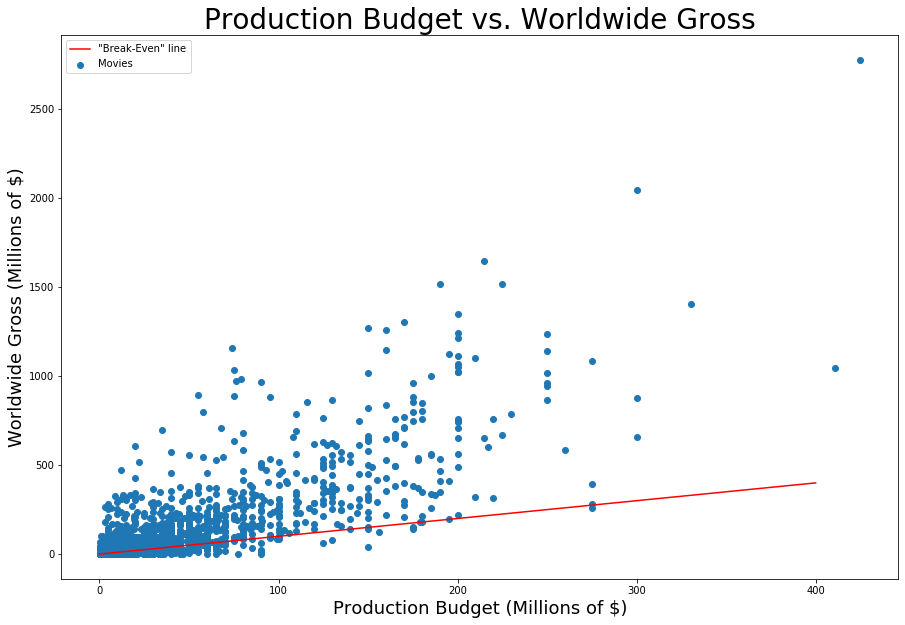

In [3]:
plt.figure(figsize=(15,10))
plt.scatter(df['production_budget'], df['worldwide_gross'])
plt.plot([0,400], [0,400], color='red')
plt.xlabel('Production Budget (Millions of $)', fontsize=18)
plt.ylabel('Worldwide Gross (Millions of $)', fontsize=18)
plt.title('Production Budget vs. Worldwide Gross', fontsize=28)
plt.savefig('production-budget-worldwide-gross-with-identity-line.png')
plt.legend(['\"Break-Even\" line', 'Movies'])
plt.show()

This almost looks like it could be modeled with a linear relationship. Would that be a wise idea? Let's compute the correlation and slope of the regression line to see what we can find out.

In [4]:
correlation = df['production_budget'].corr(df['worldwide_gross'])
slope = correlation * df['worldwide_gross'].std() / df['production_budget'].std()
print('Correlation:', round(correlation, 2))
print('Slope:      ', round(slope, 2))

Correlation: 0.8
Slope:       3.41


According to this information, we can expect to make about \\$3,000,000 more in worldwide gross for every \\$1,000,000 increase in production budget. Unfortunately, this doesn't seem to be a safe bet. There appear to be a number of films that did not make back their production budget.

In [5]:
bombs_df = df[df['production_budget'] > df['worldwide_gross']][['movie', 'production_budget', 'worldwide_gross']]

bombs_df

,movie,production_budget,worldwide_gross
2138,#Horror,1.50,0.00
1482,10 Days in a Madhouse,12.00,0.01
1902,13 Sins,4.00,0.05
2215,1982,1.00,0.00
2191,23 Blast,1.00,0.55
...,...,...,...
1849,Yoga Hosers,5.00,0.02
598,Your Highness,50.00,26.12
1871,Zipper,4.50,0.00
359,Zodiac,85.00,83.08


Yikes! Imagine investing \\$85,000,000 into Zodiac, but only making \\$83,000,000 back. You could have filmed 23 Blast and 1982 with that money (not that it would have been a good investment).

Maybe we need to make a smarter decision. Could this relationship be less favorable for some genres than others? Let's look at each genre individually and see what we can find out.

Even scarier is the proportion of movies in our dataset that do not break even:

In [6]:
round(bombs_df.shape[0] / df.shape[0], 2)

0.36

We do not want to fall into that 36%, so we need to make a more informed decision.

We'll start by analyzing the same graph, but split apart into genres.

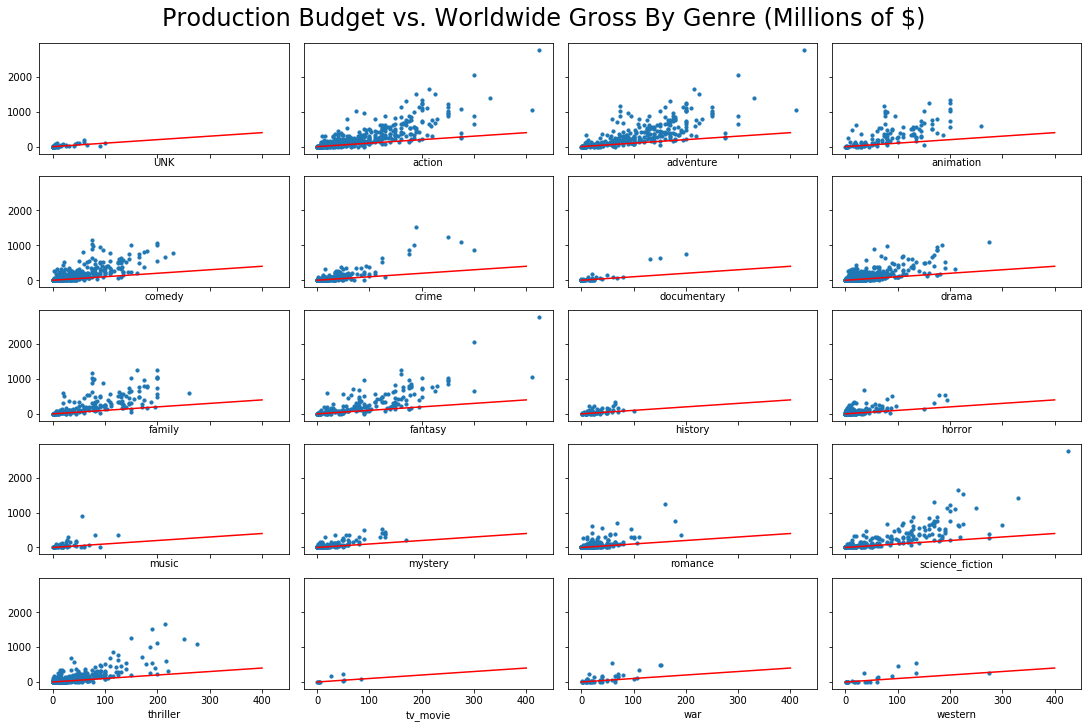

In [17]:
genres = data_loader.genre_list
num_genres = len(genres)


fig = plt.figure(figsize=(15,10), constrained_layout=True)
ax= fig.subplots(5,4, sharex=True, sharey=True)

for i in range(len(genres)):
    row = i // 4
    col = i % 4
    ax[row][col].scatter(df[df[genres[i]]]['production_budget'], df[df[genres[i]]]['worldwide_gross'], s=10)
    ax[row][col].plot([0,400],[0,400], color='red')
    ax[row][col].set_xlabel(genres[i])

#horror_ax.scatter(horror_df['production_budget'], horror_df['worldwide_gross'])
fig.suptitle('Production Budget vs. Worldwide Gross By Genre (Millions of $)', fontsize=24)
plt.savefig('pb-vs-wg-by-genre.png')
plt.show()

In the scatterplots above, we can see that each genre in the dataset seems to follow a vaguely linear trend, but that some genres (such as westerns, science fiction movies, and thrillers) have the potential to be a box office flop. We can also see that some horror movies tend to be cheap and make little money, while more expensive action and adventure movies do tend to see a positive return on their investment.

That said, we haven't even attempted to control for inflation here.

Let's look at the relationship between profitability and budget for each genre.

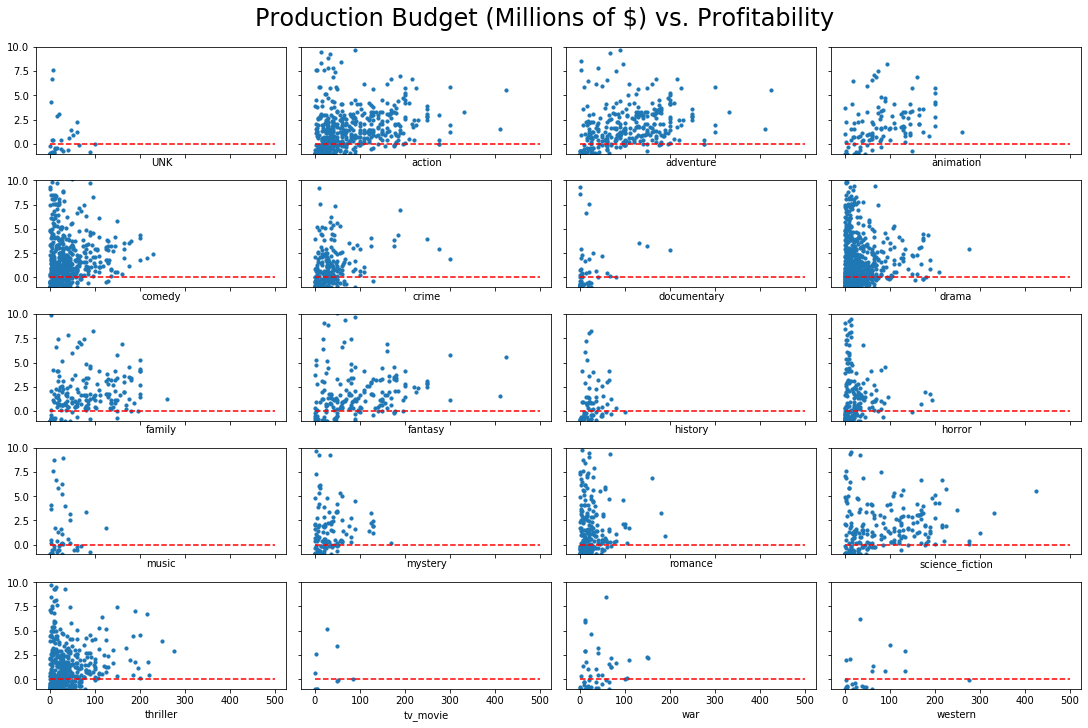

In [18]:
genres = data_loader.genre_list
num_genres = len(genres)

fig = plt.figure(figsize=(15,10), constrained_layout=True)
ax= fig.subplots(5,4, sharex=True, sharey=True)

for i in range(len(genres)):
    row = i // 4
    col = i % 4
    ax[row][col].scatter(df[df[genres[i]]]['production_budget'], df[df[genres[i]]]['profitability'], s=10)
    ax[row][col].set_xlabel(genres[i])
    ax[row][col].set_ylim(-1, 10)
    
    # below this line, the movie is losing money
    ax[row][col].plot([0,500], [0,0], 'r--')

#horror_ax.scatter(horror_df['production_budget'], horror_df['worldwide_gross'])

fig.suptitle('Production Budget (Millions of $) vs. Profitability', fontsize=24)
plt.savefig('production-budget-profitability-by-genre.png')
plt.show()

On the figures above, the region below the dashed red line represents a flop: a movie that failed to earn back its production budget in worldwide box office gross. A genre with a huge collection of dots below the red line indicates a risk––a genre where many films fail to break even. The higher up a point is, the more times it earned back its budget. 

That said, there does seem to be a trend for some genres where budgets over \\$100m tend to correspond to high profitability. Let's find the genres with the lowest proportion of negative profitability. Because some 

In [9]:
big_budget = df[df['production_budget'] > 100]

flops = pd.DataFrame(index=data_loader.genre_list, columns=['num_flops', 'total_films', 'proportion'])

for genre in flops.index:
    # divide by 1 + (number of genres) to avoid division by zero in genres that 
    # did not meet the budget criteria
    flops.loc[genre, 'num_flops'] = len(big_budget[big_budget[genre] & (big_budget['profitability'] < 0)])
    flops.loc[genre, 'total_films'] = len(big_budget[big_budget[genre]])

# get rid of genres with little to no representation
flops = flops[flops['total_films'] > 10]

flops['proportion'] = flops['num_flops'] / flops['total_films']

flops.sort_values(['proportion'])

,num_flops,total_films,proportion
thriller,0,33,0.00
family,1,57,0.02
science_fiction,2,79,0.03
animation,1,39,0.03
adventure,4,139,0.03
comedy,2,45,0.04
action,7,136,0.05
fantasy,4,68,0.06
drama,3,38,0.08
crime,1,12,0.08


From the data above, we can rule out any genres with a proportion of zero due to insufficient data.

From this, we can see that the genres with the lowest proportion of big-budget flops are thriller, family, science fieciton, animation, and adventure.

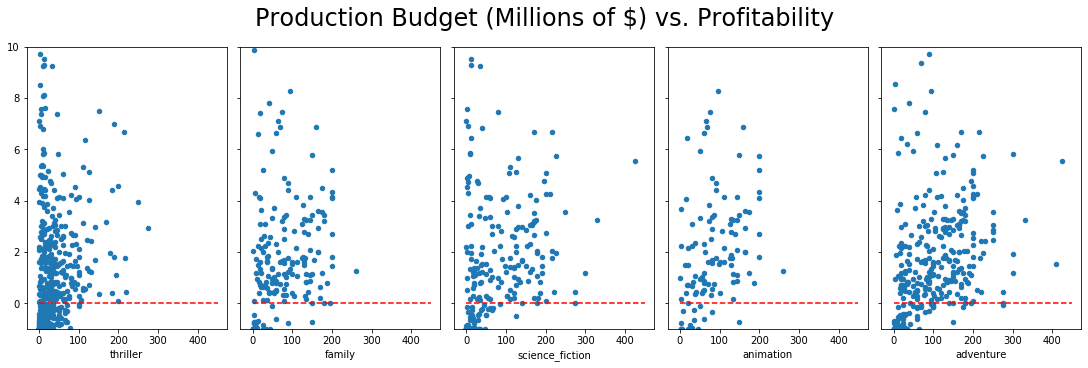

In [19]:
genres = ['thriller', 'family', 'science_fiction', 'animation', 'adventure']

fig = plt.figure(figsize=(15,5), constrained_layout=True)
ax = fig.subplots(1, 5, sharex=True, sharey=True)

['']

for i in range(len(genres)):
    ax[i].scatter(df[df[genres[i]]]['production_budget'], df[df[genres[i]]]['profitability'], s=20)
    ax[i].set_xlabel(genres[i])
    ax[i].set_ylim(-1, 10)
    
    # below this line, the movie is losing money
    ax[i].plot([0,450], [0,0], 'r--')

#horror_ax.scatter(horror_df['production_budget'], horror_df['worldwide_gross'])

fig.suptitle('Production Budget (Millions of $) vs. Profitability', fontsize=24)
plt.savefig('pb-vs-profitability-top-genres.png')
plt.show()

Based on this analysis, we recommend looking for big-budget thriller, family, science fiction, animation, and adventure scripts to get our hypothetical studio off the ground.